In [1]:
from ROOT import gROOT, TCanvas, TF1, TH1D, TFile, TPostScript, TChain, gDirectory, TTree, TH2D, TLorentzVector
from math import sqrt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import uproot
import msgpack
from matplotlib.colors import LogNorm
from matplotlib  import cm

Welcome to JupyROOT 6.21/01


In [2]:
#DAOD stuff
def RecoArray(DAODfile):
    filename = DAODfile
    file = uproot.open(filename)
    events = file["CollectionTree"]

    eventno =  events.arrays("EventInfoAux.eventNumber")[b'EventInfoAux.eventNumber']
    rphpt = events.arrays("PhotonsAuxDyn.pt")[b'PhotonsAuxDyn.pt']
    rpheta = events.arrays("PhotonsAuxDyn.eta")[b'PhotonsAuxDyn.eta']
    rphphi = events.arrays("PhotonsAuxDyn.phi")[b'PhotonsAuxDyn.phi']
    rphm = events.arrays("PhotonsAuxDyn.m")[b'PhotonsAuxDyn.m']

    recoarray = {}
    for i in range(events.numentries):
   # if i >= 190000:
         #if len(rphpt[i]) < 2: print "less than 2 reco photons : event: %s  numphotons: %s" % (eventno[i],len(rphpt[i]))
         if len(rphpt[i]) >= 2:
            recoarray[eventno[i]] = []
            for j in range(len(rphpt[i])):
                if rphpt[i][j]/1000 < 25:
                    #print "photon pt less than 25GeV: event: %s recophotonnum: %s" % (i,j)
                    continue
                else:
                    g = TLorentzVector()
                    g.SetPtEtaPhiM(rphpt[i][j]/1000,rpheta[i][j],rphphi[i][j],rphm[i][j]/1000)
                    recoarray[eventno[i]].append(g)
            ######################################## sorting reco array by E #########################################################
    RecoArray = {}
    for i in recoarray.keys():
        tempdict = {}
    #print len(recoarray[i])
#    if len(recoarray[i]) < 2:
#        print "more than 1 reco photon but not more than 1 reco photon with pt > 25 in event : %s" % eventno[i]
#    else:
        if len(recoarray[i]) >= 2:
            for j in recoarray[i]:
                tempdict[j.E()]=j
            sortedPtlist = sorted(tempdict.keys(), reverse = True)
            RecoArray["%s" % i] = []
            for p in sortedPtlist:
                RecoArray["%s" % i].append(tempdict[p])
                
    return RecoArray

def TruthArray(DAODfile):
    filename = DAODfile
    file = uproot.open(filename)
    events = file["CollectionTree"]

    eventno =  events.arrays("EventInfoAux.eventNumber")[b"EventInfoAux.eventNumber"]
    tphpx = events.arrays('TruthPhotonsAuxDyn.px')[b'TruthPhotonsAuxDyn.px']
    tphpy = events.arrays('TruthPhotonsAuxDyn.py')[b'TruthPhotonsAuxDyn.py']
    tphpz = events.arrays('TruthPhotonsAuxDyn.pz')[b'TruthPhotonsAuxDyn.pz']
    tphe = events.arrays('TruthPhotonsAuxDyn.e')[b'TruthPhotonsAuxDyn.e']
    
    trutharray = {}
    for i in range(events.numentries):
         if sqrt((tphpx[i][0]/1000)**2 + (tphpy[i][0]/1000)**2) > 25. and sqrt((tphpx[i][1]/1000)**2 + (tphpy[i][1]/1000)**2) > 25. :
            g1 = TLorentzVector()
            g1.SetPxPyPzE(tphpx[i][0],tphpy[i][0],tphpz[i][0],tphe[i][0])
            g2 = TLorentzVector()
            g2.SetPxPyPzE(tphpx[i][1],tphpy[i][1],tphpz[i][1],tphe[i][1])
            if g1.DeltaR(g2) > 0:
                trutharray[eventno[i]] = []
                #trutharray[eventno[i]].append([vertex['TruthVerticesAuxDyn.x'][i][0],vertex['TruthVerticesAuxDyn.y'][i][0],vertex['TruthVerticesAuxDyn.z'][i][0]])
                trutharray[eventno[i]].append(g1)
                trutharray[eventno[i]].append(g2)
                #trutharray[eventno[i]].append(g1+g2)
                #trutharray[eventno[i]].append([primver['PrimaryVerticesAuxDyn.x'][i][0],primver['PrimaryVerticesAuxDyn.y'][i][0],primver['PrimaryVerticesAuxDyn.z'][i][0]])
    
    TruthArray = {}
    for i in trutharray.keys():
        tempdict = {}
    #print len(recoarray[i])
#    if len(recoarray[i]) < 2:
#        print "more than 1 reco photon but not more than 1 reco photon with pt > 25 in event : %s" % eventno[i]
#    else:
        if len(trutharray[i]) >= 2:
            for j in trutharray[i]:
                tempdict[j.E()]=j
            sortedPtlist = sorted(tempdict.keys(), reverse = True)
            TruthArray["%s" % i] = []
            for p in sortedPtlist:
                TruthArray["%s" % i].append(tempdict[p])
                
    return TruthArray

def vtx(DAODfile):
    filename = DAODfile
    file = uproot.open(filename)
    events = file["CollectionTree"]
    
    eventno =  events.arrays("EventInfoAux.eventNumber")[b"EventInfoAux.eventNumber"]
    vertex = events.arrays("TruthVerticesAuxDyn.[xyz]")
    primver = events.arrays('PrimaryVerticesAuxDyn.[xyz]')
    
    vtx = {}
    for i in range(events.numentries):
        vtx["%s" % eventno[i]] = []
        vtx["%s" % eventno[i]].append([float(vertex[b'TruthVerticesAuxDyn.x'][i][0])/10.,float(vertex[b'TruthVerticesAuxDyn.y'][i][0])/10.,float(vertex[b'TruthVerticesAuxDyn.z'][i][0])/10.])
        vtx["%s" % eventno[i]].append([float(primver[b'PrimaryVerticesAuxDyn.x'][i][0])/10.,float(primver[b'PrimaryVerticesAuxDyn.y'][i][0])/10.,float(primver[b'PrimaryVerticesAuxDyn.z'][i][0])/10.])

    return vtx
# CHECK UNITS OF VTXS!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [3]:
#making DAOD arrays
#print("making reco array")
recoarray = RecoArray("DAOD_HIGG1D1.17971793._000001.pool.root.1");
recoarray.update(RecoArray("DAOD_HIGG1D1.17971793._000002.pool.root.1"));
recoarray.update(RecoArray("DAOD_HIGG1D1.17971793._000003.pool.root.1"));
recoarray.update(RecoArray("DAOD_HIGG1D1.17971793._000004.pool.root.1"));
#print(len(recoarray.keys()))
#print("reco array done")
#print("")
#print("making truth ary")
trutharray = TruthArray("DAOD_HIGG1D1.17971793._000001.pool.root.1");
trutharray.update(TruthArray("DAOD_HIGG1D1.17971793._000002.pool.root.1"));
trutharray.update(TruthArray("DAOD_HIGG1D1.17971793._000003.pool.root.1"));
trutharray.update(TruthArray("DAOD_HIGG1D1.17971793._000004.pool.root.1"));
#print(len(trutharray.keys()))
#print("truthart done")
#print(" ")
#print("now making vtx dict")
vtex = vtx("DAOD_HIGG1D1.17971793._000001.pool.root.1");
vtex.update(vtx("DAOD_HIGG1D1.17971793._000002.pool.root.1"));
vtex.update(vtx("DAOD_HIGG1D1.17971793._000003.pool.root.1"));
vtex.update(vtx("DAOD_HIGG1D1.17971793._000004.pool.root.1"));
#print(len(vtex.keys()));
#print("vtx done")

In [4]:
#misc defs
def cuboid_data(p, size=(1,1,1)):
    # code taken from
    # https://stackoverflow.com/a/35978146/4124317
    # suppose axis direction: x: to left; y: to inside; z: to upper
    # get the length, width, and height
    l, w, h = size
    o = [a - b / 2 for a, b in zip(p, size)]
    x = [[o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]],  
         [o[0], o[0] + l, o[0] + l, o[0], o[0]]]  
    y = [[o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1] + w, o[1] + w, o[1]],  
         [o[1], o[1], o[1], o[1], o[1]],          
         [o[1] + w, o[1] + w, o[1] + w, o[1] + w, o[1] + w]]   
    z = [[o[2], o[2], o[2], o[2], o[2]],                       
         [o[2] + h, o[2] + h, o[2] + h, o[2] + h, o[2] + h],   
         [o[2], o[2], o[2] + h, o[2] + h, o[2]],               
         [o[2], o[2], o[2] + h, o[2] + h, o[2]]]               
    return np.array(x), np.array(y), np.array(z)

def plotCubeAt(pos=(0,0,0), size=(1,1,1), ax=None,**kwargs):
    # Plotting a cube element at position pos
    if ax !=None:
        X, Y, Z = cuboid_data( pos, size )
        ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.2, **kwargs)
        
def intersection(lst1, lst2): 
  
    # Use of hybrid method 
    temp = set(lst2) 
    lst3 = [value for value in lst1 if value in temp] 
    return lst3 

def D_vtx(a,b):
    dist = (a[0] - b[0])**2 + (a[1] - b[1])**2 + (a[2] - b[2])**2
    return sqrt(dist)

def ncoordchange(cell):
    eta = cell[1]
    phi = cell[2]
    r = cell[3]
    z = cell[4]
    samp = cell[5]
    
    theta = 2*np.arctan(np.exp(eta))
    
    if eta >= 0:
        z1 = abs(r*np.cos(theta)/sqrt(1 - (np.cos(theta))**2))
    elif eta < 0:
        z1 = -abs(r*np.cos(theta)/sqrt(1 - (np.cos(theta))**2))
        
    if (phi <= 1.57079632679 and phi >= 0) or (phi <= 6.28318530718 and phi >= 4.71238898038):
        x = abs(r/sqrt(1 + (np.tan(phi))**2))
    else: x = -abs(r/sqrt(1 + (np.tan(phi))**2))
    y = np.tan(phi)*x
        
    return [x,y,z]

def recoprintcheck(ev): 
    print("event number : %s" % ev)
    print("number of reco photons in event : %s" % len(recoarray[ev])) 
    print(" ") 
    for i in range(len(recoarray[ev])):
        print("photon %s E : %s" % (i+1,recoarray[ev][i].E())) 
        print("photon %s Eta : %s" %(i+1,recoarray[ev][i].Eta())) 
        print("photon %s Phi : %s" %(i+1,recoarray[ev][i].Phi())) 
        print(" ") 
        
def truthprintcheck(ev): 
    print("event number : %s" % ev) 
    print("number of truth photons in event : %s" % (len(trutharray[ev]))) 
    print(" ") 
    for i in range(len(trutharray[ev])):
        print("photon %s E : %s" % (i+1,trutharray[ev][i].E())) 
        print("photon %s Eta : %s" %(i+1,trutharray[ev][i].Eta())) 
        print("photon %s Phi : %s" %(i+1,trutharray[ev][i].Phi())) 
        print(" ") 
        
def plot_layers(ev):
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    ax.set_title("(eta, phi, energy) for layer 0, eventnumber = %s" % ev,fontsize=14) 
    ax.set_xlabel("eta",fontsize=12)
    ax.set_ylabel("phi",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    sc = plt.scatter([x[1] for x in cinfo[ev] if x[5]==0],[x[2] for x in cinfo[ev] if x[5]==0],c=[x[0] for x in cinfo[ev] if x[5]==0],s=20, cmap = cm.jet, alpha=1);
    plt.colorbar(sc)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.575', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    ax.set_title("(eta, phi, energy) for layer 1, eventnumber = %s" % ev,fontsize=14)
    ax.set_xlabel("eta",fontsize=12)
    ax.set_ylabel("phi",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    sc = plt.scatter([x[1] for x in cinfo[ev] if x[5]==1],[x[2] for x in cinfo[ev] if x[5]==1],c=[x[0] for x in cinfo[ev] if x[5]==1],s=5, cmap = cm.jet, alpha=1);
    plt.colorbar(sc)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.575', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')


    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    ax.set_title("(eta, phi, energy) for layer 2, eventnumber = %s" % ev,fontsize=14)
    ax.set_xlabel("eta",fontsize=12)
    ax.set_ylabel("phi",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    sc = plt.scatter([x[1] for x in cinfo[ev] if x[5]==2],[x[2] for x in cinfo[ev] if x[5]==2],c=[x[0] for x in cinfo[ev] if x[5]==2],s=5, cmap = cm.jet, alpha=1);
    plt.colorbar(sc)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.575', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
   


    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot(111)
    ax.set_title("(eta, phi, energy) for layer 3, eventnumber = %s" % ev,fontsize=14)
    ax.set_xlabel("eta",fontsize=12)
    ax.set_ylabel("phi",fontsize=12)
    ax.grid(True,linestyle='-',color='0.75')
    sc = plt.scatter([x[1] for x in cinfo[ev] if x[5]==3],[x[2] for x in cinfo[ev] if x[5]==3],c=[x[0] for x in cinfo[ev] if x[5]==3],s=5, cmap = cm.jet, alpha=1);
    plt.colorbar(sc)
    ax.minorticks_on()
    ax.grid(which='major', linestyle='-', linewidth='0.575', color='black')
    ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
    
def prob_plot(sample):
##making probabiity of ct>pt as a fn of |c|
    b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42 = ([] for i in range(42))
    for i in sample:
        d = D_vtx(cands[i],[0,0,0])
        if d <= 5.: 
            b1.append(i)
        elif d > 5. and d <= 10.: 
            b2.append(i)
        elif d > 10. and d <= 15.: 
            b3.append(i)
        elif d > 15. and d <= 20.: 
            b4.append(i)
        elif d > 20. and d <= 25.: 
            b5.append(i)
        elif d > 25. and d <= 30.: 
            b6.append(i)
        elif d > 30. and d <= 35.: 
            b7.append(i)
        elif d > 35. and d <= 40.: 
            b8.append(i)
        elif d > 40. and d <= 45.: 
            b9.append(i)
        elif d > 45. and d <= 50.: 
            b10.append(i)
        elif d > 50. and d <= 55.: 
            b11.append(i)
        elif d > 55. and d <= 60.: 
            b12.append(i)
        elif d > 60. and d <= 65.: 
            b13.append(i)
        elif d > 65. and d <= 70.: 
            b14.append(i)
        elif d > 70. and d <= 75.: 
            b15.append(i)
        elif d > 75. and d <= 80.: 
            b16.append(i)
        elif d > 80. and d <= 85.: 
            b17.append(i)
        elif d > 85. and d <= 90.: 
            b18.append(i)
        elif d > 90. and d <= 95.: 
            b19.append(i)
        elif d > 95. and d <= 100.: 
            b20.append(i)
        elif d > 100. and d <= 105.: 
            b21.append(i)
        elif d > 105. and d <= 110.: 
            b22.append(i)
        elif d > 110. and d <= 115.: 
            b23.append(i)
        elif d > 115. and d <= 120.: 
            b24.append(i)
        elif d > 120. and d <= 125.: 
            b25.append(i)
        elif d > 125. and d <= 130.: 
            b26.append(i)
        elif d > 130. and d <= 135.: 
            b27.append(i)
        elif d > 135. and d <= 140.: 
            b28.append(i)
        elif d > 140. and d <= 145.: 
            b29.append(i)
        elif d > 145. and d <= 150.: 
            b30.append(i)
        elif d > 150. and d <= 155.: 
            b31.append(i)
        elif d > 155. and d<= 160.: 
            b32.append(i)
        elif d > 160. and d <= 165.: 
            b33.append(i)
        elif d > 165. and d <= 170.: 
            b34.append(i)
        elif d > 170. and d<= 175.: 
            b35.append(i)
        elif d > 175. and d <= 180.: 
            b36.append(i)
        elif d > 180. and d <= 185.: 
            b37.append(i)
        elif d > 185. and d <= 190.: 
            b38.append(i)
        elif d > 190. and d <= 195.: 
            b39.append(i)
        elif d > 195. and d <= 200.: 
            b40.append(i)
        elif d > 200. and d <= 205.: 
            b41.append(i)
        else:
            b42.append(i)
    bins = [b1,b2,b3,b4,b5,b6,b7,b8,b9,b10,b11,b12,b13,b14,b15,b16,b17,b18,b19,b20,b21,b22,b23,b24,b25,b26,b27,b28,b29,b30,b31,b32,b33,b34,b35,b36,b37,b38,b39,b40,b41,b42]
    #problist = [(len([ev for ev in b if D_vtx(algo(ev),vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b)) for b in bins if len(b) != 0]
    valuelist = []
    for b in bins:
        if len(b) != 0:
            valuelist.append(len([ev for ev in b if D_vtx(cands[ev],vtex[ev][0]) < D_vtx(vtex[ev][1],vtex[ev][0])])/len(b))
        else:
            valuelist.append(0)
    
    plt.scatter(list(range(0,210,5)),valuelist)
    plt.xlabel("distance of cand vtx from origin, in cm");
    plt.ylabel("prob of |cand-truth| < |prim-truth|");
    plt.show()
    
def inv_mass_plot(sample):
    #we want for every event, to calculate invariant mass, put it on a histogram
    vals = []
    sr = 0.25
    #going to average eta and phi through the layers for each photon, gonna use summed E as given
    for i in sample:
        cells = picktop2(i)
        p1 = cells["1"]
        p2 = cells["2"]
        eta1 = np.mean([p1[i][1] for i in p1.keys()])
        eta2 = np.mean([p2[i][1] for i in p2.keys()])
        phi1 = np.mean([p1[i][2] for i in p1.keys()])
        phi2 = np.mean([p2[i][2] for i in p2.keys()])
        E1 = np.sum([p1[i][0] for i in p1.keys()])
        E2 = np.sum([p2[i][0] for i in p2.keys()])
        mass = sqrt(2*E1*E2*(np.cosh(eta1 - eta2) - np.cos(phi1 - phi2)))
        vals.append(mass/1000)
    plt.hist(vals,bins=100,range=[0,500])
    plt.show()
    
def checkKey(dict, key): 
      
    if key in dict: 
        return True
    else: 
        return False

In [18]:
#picking top 2 cells from layer 2 - only making sure both cells are not the same cell
def picktop2(ev,sr,ir):
    top2 = {"1":{},"2":{}}
    cell_list_2 = sorted([x for x in cinfo[ev] if x[5]==2],reverse=True)
    cell_list_3 = sorted([x for x in cinfo[ev] if x[5]==3],reverse=True)
    cell_list_0 = sorted([x for x in cinfo[ev] if x[5]==0],reverse=True)
    cell_list_1 = sorted([x for x in cinfo[ev] if x[5]==1],reverse=True)
    
    ####photon1
    #layer2
    top2["1"][2] = cell_list_2[0]
    #layer3
    for i in range(len(cell_list_3)):
            if abs(top2["1"][2][1] - cell_list_3[i][1]) < sr and abs(top2["1"][2][2] - cell_list_3[i][2]) < sr:
                top2["1"][3] = cell_list_3[i]
                break
            else: continue

    #layer1
    for i in range(len(cell_list_1)):
            if abs(top2["1"][2][1] - cell_list_1[i][1]) < sr and abs(top2["1"][2][2] - cell_list_1[i][2]) < sr:
                top2["1"][1] = cell_list_1[i]
                break
            else: continue
    #layer0
    for i in range(len(cell_list_0)):
            if abs(top2["1"][2][1] - cell_list_0[i][1]) < sr and abs(top2["1"][2][2] - cell_list_0[i][2]) < sr:
                top2["1"][0] = cell_list_0[i]
                break
            else: continue

    ###photon2
    #layer2
    for j in range(len(cell_list_2)):
            if not(abs(cell_list_2[j][1] - top2["1"][2][1]) <= ir and abs(cell_list_2[j][2] - top2["1"][2][2]) <= ir): 
                top2["2"][2] = cell_list_2[j]
                break
            else: 
                continue
    
    #layer3
    for j in range(len(cell_list_3)):
        if checkKey(top2["1"],3) and checkKey(top2["2"],2):
            if not(abs(cell_list_3[j][1] - top2["1"][3][1]) <= ir and abs(cell_list_3[j][2] - top2["1"][3][2]) <= ir): 
                if abs(cell_list_3[j][1] - top2["2"][2][1]) < sr and abs(cell_list_3[j][2] - top2["2"][2][2]) < sr:
                    top2["2"][3] = cell_list_3[j]
                    break
                else: continue
        elif checkKey(top2["2"],2):
            if abs(cell_list_3[j][1] - top2["2"][2][1]) < sr and abs(cell_list_3[j][2] - top2["2"][2][2]) < sr:
                    top2["2"][3] = cell_list_3[j]
                    break
            else: continue
        else: continue
    
    #layer1
    for j in range(len(cell_list_1)):
        if checkKey(top2["1"],1) and checkKey(top2["2"],2):
            if not(abs(cell_list_1[j][1] - top2["1"][1][1]) <= ir and abs(cell_list_1[j][2] - top2["1"][1][2]) <= ir):
                if abs(cell_list_1[j][1] - top2["2"][2][1]) < sr and abs(cell_list_1[j][2] - top2["2"][2][2]) < sr:
                    top2["2"][1] = cell_list_1[j]
                    break
                else: continue
        elif checkKey(top2["2"],2):
            if abs(cell_list_1[j][1] - top2["2"][2][1]) < sr and abs(cell_list_1[j][2] - top2["2"][2][2]) < sr:
                    top2["2"][1] = cell_list_1[j]
                    break
            else: continue
            
        else: continue
    #layer0
    for j in range(len(cell_list_0)):
        if checkKey(top2["1"],0) and checkKey(top2["2"],2):
            if not(abs(cell_list_0[j][1] - top2["1"][0][1]) <= ir and abs(cell_list_0[j][2] - top2["1"][0][2]) <= ir): 
                if abs(cell_list_0[j][1] - top2["2"][2][1]) < sr and abs(cell_list_0[j][2] - top2["2"][2][2]) < sr:
                    top2["2"][0] = cell_list_0[j]
                    break
                else: continue
        elif checkKey(top2["2"],2):
            if abs(cell_list_0[j][1] - top2["2"][2][1]) < sr and abs(cell_list_0[j][2] - top2["2"][2][2]) < sr:
                    top2["2"][0] = cell_list_0[j]
                    break
            else: continue
                
        else: continue
                    
    return top2

In [19]:
#to find cand vtx given ev
badevs = {}
def algo(ev,sr=0.125,ir=0.1,plot=False,dist=False):
    cells = picktop2(ev,sr,ir)
    erphi = {0:0.025,1:0.0031,2:0.025,3:0.05}
    ereta = {0:0.01,1:0.0098,2:0.00245,3:0.0025}
    colorse = {"1":{0:"lightsteelblue",1:"cornflowerblue",2:"royalblue",3:"darkblue",},"2":{0:"lightcoral",1:"indianred",2:"brown",3:"maroon"}}
    
    data1 = []
    data2 = []
    
    positions = []
    sizes = []
    colors = []
    
    if len(cells["1"].keys()) != 4 or len(cells["2"].keys()) != 4:
        badevs[ev] = cells
    
    for i in cells["1"].keys():
        cell = cells["1"][i]
        pt = ncoordchange(cell)
        data1.append(pt)
        if plot == True:
            positions.append(pt)
            sizes.append([abs(pt[0] - ncoordchange([cell[0],cell[1],cell[2]+erphi[i],cell[3],cell[4],cell[5]])[0]),abs(pt[1] - ncoordchange([cell[0],cell[1],cell[2]+erphi[i],cell[3],cell[4],cell[5]])[1]),abs(pt[2] - ncoordchange([cell[0],cell[1]+ereta[i],cell[2],cell[3],cell[4],cell[5]])[2])])
            colors.append(colorse["1"][i])
    for i in cells["2"].keys():
        cell = cells["2"][i]
        pt = ncoordchange(cell)
        data2.append(pt)
        if plot == True:
            positions.append(pt)
            sizes.append([abs(pt[0] - ncoordchange([cell[0],cell[1],cell[2]+erphi[i],cell[3],cell[4],cell[5]])[0]),abs(pt[1] - ncoordchange([cell[0],cell[1],cell[2]+erphi[i],cell[3],cell[4],cell[5]])[1]),abs(pt[2] - ncoordchange([cell[0],cell[1]+ereta[i],cell[2],cell[3],cell[4],cell[5]])[2])])
            colors.append(colorse["2"][i])
    
    data1mean = np.mean(data1,axis=0)
    uu1, dd1, vv1 = np.linalg.svd(data1 - data1mean)
    
    t = np.linspace(-250,250, 1000)
    x1line = data1mean[0] + vv1[0][0] * t
    y1line = data1mean[1] + vv1[0][1] * t
    z1line = data1mean[2] + vv1[0][2] * t
    
    data2mean = np.mean(data2,axis=0)
    uu2, dd2, vv2 = np.linalg.svd(data2 - data2mean)

    x2line = data2mean[0] + vv2[0][0] * t
    y2line = data2mean[1] + vv2[0][1] * t
    z2line = data2mean[2] + vv2[0][2] * t

    #To find candidate intersection between two tracks
    n2 = np.cross(vv2[0],(np.cross(vv1[0],vv2[0])))
    n1 = np.cross(vv1[0],(np.cross(vv2[0],vv1[0])))

    c1 = data1mean + ((np.dot((data2mean - data1mean),n2))/(np.dot(vv1[0],n2)))*vv1[0]
    c2 = data2mean + ((np.dot((data1mean - data2mean),n1))/(np.dot(vv2[0],n1)))*vv2[0]
    candvtx = (c1 + c2)/2
    
    if plot == True:
                truth = vtex[ev][0]
                prim = vtex[ev][1]
                
                print("shortest distance between 'tracks' is: %s" % D_vtx(c1,c2))
        
                fig = plt.figure(figsize=(5,5))
                ax = fig.add_subplot(111,projection='3d');
                ax.scatter([i[0] for i in data1], [i[1] for i in data1], [i[2] for i in data1], c='blue',label="photon 1 pts")
                ax.plot3D(x1line, y1line, z1line, 'darkblue',label = "photon 1 'track'")
                ax.scatter([i[0] for i in data2], [i[1] for i in data2], [i[2] for i in data2], c='red',label = "photon 2 pts")
                ax.plot3D(x2line, y2line, z2line, 'darkred',label="phton 2 'track'")
                ax.scatter(candvtx[0],candvtx[1],candvtx[2],c='black', label = "candidate vtx")
                ax.scatter3D(truth[0],truth[1],truth[2],c="purple",label = "truth vtx");
                ax.scatter3D(prim[0],prim[1],prim[2],c="green",label = "primary vtx");

                for p,s,c in zip(positions,sizes,colors):
                    plotCubeAt(pos=p, size=s, ax=ax, color=c)
        
                ax.set_xlabel('X ');
                ax.set_ylabel('Y ');
                ax.set_zlabel('Z ');
                ax.legend()
                #ax.set_title(" 'track' reconstruction for eventnumber = %s" % ev,fontsize=14)
                
                return candvtx
        
    if dist == True:
        return [candvtx,D_vtx(c1,c2)]
    
    else: return candvtx

In [7]:
# makes channel-id to eta,phi,r,z,layer map
def Map(file_name):
    map = {}
    with open(file_name,"r") as f:
        line = f.readline()
        for line in f:
            map[line.split()[0]] = [float(line.split()[4]),float(line.split()[5]),float(line.split()[6])/10.,float(line.split()[7])/10.,int(line.split()[3])]
    return map

map = Map("map.txt")

In [8]:
#unpickle Cell level info
with open('cinfo.msgpack','rb') as data_file:
    # data_loaded = json.load(data_file)
    cinfo = msgpack.unpack(data_file)

In [28]:
sample = intersection(recoarray.keys(),trutharray.keys())
sample = intersection(sample, cinfo.keys())
seeample = []
cands0 = {}
cands1 = {}
cands2 = {}
cands3 = {}
cands4 = {}
cands5 = {}

for i in sample:
    d0 = algo(i,sr=0.125,ir=0.1,dist=True)
    d1 = algo(i,sr=0.15,ir=0.1)
    d2 = algo(i,sr=0.1,ir=0.1)
    d3 = algo(i,sr=0.125,ir=0.075)
    d4 = algo(i,sr=0.15,ir=0.075)
    d5 = algo(i,sr=0.1,ir=0.075)
    
    if (vtex[i][0][0])**2 + (vtex[i][0][1])**2 <= 13225.:
        if (d0[0][0])**2 + (d0[0][1])**2 < 13235.:
            cands0[i] = [float(d0[0][0]),float(d0[0][1]),float(d0[0][2])]
        if d0[1] <= 10.:
            seeample.append(i)
        if (d1[0])**2 + (d1[1])**2 < 13235:
            cands1[i] = [float(d1[0]),float(d1[1]),float(d1[2])]
        if (d2[0])**2 + (d2[1])**2 < 13235:
            cands2[i] = [float(d2[0]),float(d2[1]),float(d2[2])]
        if (d3[0])**2 + (d3[1])**2 < 13235:
            cands3[i] = [float(d3[0]),float(d3[1]),float(d3[2])]
        if (d4[0])**2 + (d4[1])**2 < 13235:
            cands4[i] = [float(d4[0]),float(d4[1]),float(d4[2])]
        if (d5[0])**2 + (d5[1])**2 < 13235:
            cands5[i] = [float(d5[0]),float(d5[1]),float(d5[2])]

In [29]:
import msgpack

with open('cands0.msgpack', 'wb') as outfile:
    msgpack.pack(cands0, outfile)
with open('cands1.msgpack', 'wb') as outfile:
    msgpack.pack(cands1, outfile)
with open('cands2.msgpack', 'wb') as outfile:
    msgpack.pack(cands2, outfile)
with open('cands3.msgpack', 'wb') as outfile:
    msgpack.pack(cands3, outfile)
with open('cands4.msgpack', 'wb') as outfile:
    msgpack.pack(cands4, outfile)
with open('cands5.msgpack', 'wb') as outfile:
    msgpack.pack(cands5, outfile)
with open('cands6.msgpack', 'wb') as outfile:
    msgpack.pack(cands6, outfile)
with open('cands7.msgpack', 'wb') as outfile:
    msgpack.pack(cands7, outfile)
with open('cands8.msgpack', 'wb') as outfile:
    msgpack.pack(cands8, outfile)

In [ ]:
#########################################begin analysis##############################################

In [ ]:
def test(ev,plot = False):
    cand = algo(ev,plot)
    truth = vtex[ev][0]
    prim = vtex[ev][1]
    
    print("distance between candidate and truth vertices is %s" % D_vtx(cand,truth))
    print("distance between primary and truth vertices is %s" % D_vtx(prim,truth))
    print("distance between primary and candidate vertices is %s" % D_vtx(prim,cand))
    print("")
    print("candidate vertex is:")
    print(cand)
    print("")
    print("truth vertex is:")
    print(truth)
    print("")
    print("primary vertex is:")
    print(prim)
    print("")
    print("Reco photons:")
    recoprintcheck(ev)
    print(" ")
    print("truth photons:")
    truthprintcheck(ev)

In [26]:
len(seeample)

22808

In [ ]:
#%matplotlib notebook
#D_vtx histogram (2 in 1)
plt.hist([[D_vtx(algo(sample[i]),vtex[sample[i]][0]) for i in range(len(sample))],[D_vtx(vtex[sample[i]][1],vtex[sample[i]][0]) for i in range(len(sample))]],bins=100,range=[0,300],alpha=0.333,label=["cand-truth","prim-truth"])
plt.xlabel("distance between vertices in cm");
plt.ylabel("number of events");
plt.legend();
plt.show()

<IPython.core.display.Javascript object>


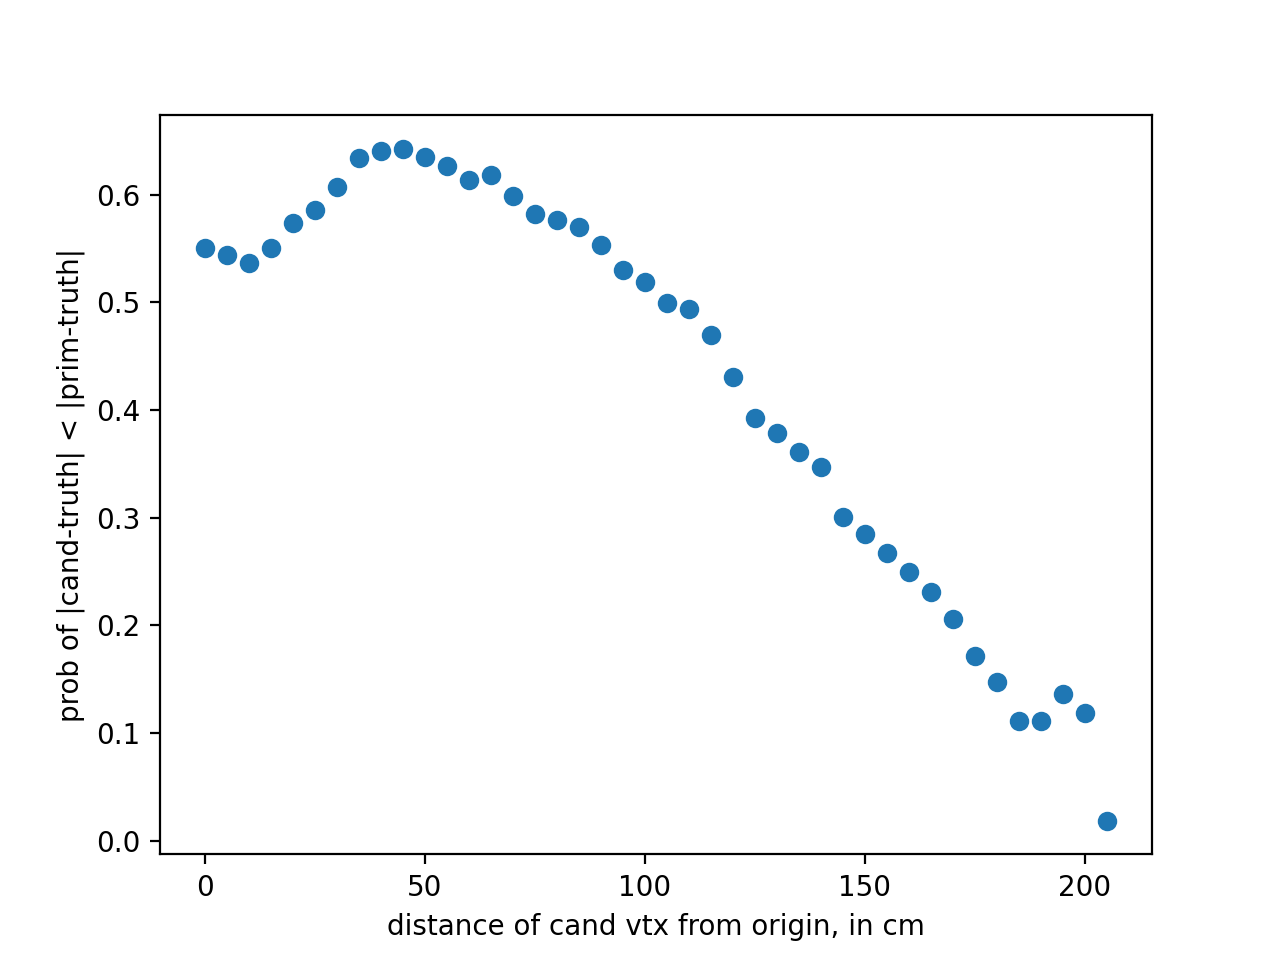

In [10]:
%matplotlib notebook
prob_plot(sample)

In [11]:
def ang_sep(ev):
    cell1 = picktop2(ev)["1"][2]
    cell2 = picktop2(ev)["2"][2]
    e1 = cell1[1]
    e2 = cell2[1]
    p1 = cell1[2]
    p2 = cell2[2]
    dr = (e1 - e2)**2 + (p1 - p2)**2
    return dr % (2*np.pi)

In [14]:
cands = {}
for i in sample:
    cands[i] = algo(i)

In [28]:
for i in cands.keys():
    cands[i] = [float(cands[i][0]),float(cands[i][1]),float(cands[i][2])]

In [30]:
import msgpack

with open('seeample.msgpack', 'wb') as outfile:
    msgpack.pack(seeample, outfile)


In [ ]:
#making zamples wrt cand vtx

zample1a = []
zample1b = []
zample1c = []
zample1d = []
zample1e = []
zample1f = []
zample2a = []
zample2b = []
zample2c = []
zample2d = []
zample2e = []
zample4a = []
zample4b = []
zample4c = []
zample4d = []
zample4e = []
zample4f = []
zample4g = []
zample4h = []
zample4i = []
zample4j = []
zample4k = []

for i in sample:
    cand = cands[i]
    
    if ((cand[0])**2 + (cand[1])**2 ) < 625.:
        zample1a.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 625. and ((cand[0])**2 + (cand[1])**2 ) < 2500.:
        zample1b.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 2500. and ((cand[0])**2 + (cand[1])**2 ) < 5625.:
        zample1c.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 5625. and ((cand[0])**2 + (cand[1])**2 ) < 10000.:
        zample1d.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 10000. and ((cand[0])**2 + (cand[1])**2 ) < 13225.:
        zample1e.append(i)
    if ((cand[0])**2 + (cand[1])**2 ) >= 13225.:
        zample1f.append(i)
        
    if abs(cand[2]) < 25.:
        zample2a.append(i)
    if abs(cand[2]) >= 25. and abs(cand[2]) < 50.:
        zample2b.append(i) 
    if abs(cand[2]) >= 50. and abs(cand[2]) < 75.:
        zample2c.append(i) 
    if abs(cand[2]) >= 75. and abs(cand[2]) < 100.:
        zample2d.append(i)
    if abs(cand[2]) >= 100.:
        zample2e.append(i)
        
    if ang_sep(i) < np.pi/24.:
        zample4a.append(i)
    if ang_sep(i) >= np.pi/24. and ang_sep(i) < np.pi/12. :
        zample4b.append(i)
    if ang_sep(i) >= np.pi/12. and ang_sep(i) < np.pi/10. :
        zample4c.append(i)
    if ang_sep(i) >= np.pi/10. and ang_sep(i) < np.pi/8. :
        zample4d.append(i)
    if ang_sep(i) >= np.pi/8. and ang_sep(i) < np.pi/6. :
        zample4e.append(i)
    if ang_sep(i) >= np.pi/6. and ang_sep(i) < np.pi/5. :
        zample4f.append(i)
    if ang_sep(i) >= np.pi/5. and ang_sep(i) < np.pi/4. :
        zample4g.append(i)
    if ang_sep(i) >= np.pi/4. and ang_sep(i) < np.pi/3. :
        zample4h.append(i)
    if ang_sep(i) >= np.pi/3. and ang_sep(i) < np.pi/2. :
        zample4i.append(i)
    if ang_sep(i) >= np.pi/2. and ang_sep(i) < np.pi :
        zample4j.append(i)
    if ang_sep(i) >= np.pi :
        zample4k.append(i)
    
    else: continue
        
listz = [zample1a,zample1b,zample1c,zample1d,zample1e,zample1f,zample2a,zample2b,zample2c,zample2d,zample2e,zample4a,zample4b,zample4c,zample4d,zample4e,zample4f,zample4g,zample4h,zample4i,zample4j,zample4k]

for i in range(len(listz)):
    print("zample %s : %s events" % (i,len(listz[i])))

In [ ]:
#plotting zamples
for i in range(len(listz)):
    print("--------zample %s"% i)
    Sample = listz[i]
    print("%i events" % len(Sample))
    plt.hist([[D_vtx(cand[Sample[i]],vtex[Sample[i]][0]) for i in range(len(Sample))],[D_vtx(vtex[Sample[i]][1],vtex[Sample[i]][0]) for i in range(len(Sample))]],bins=100,range=[0,300],alpha=0.333,label=["candidate-truth","primary-truth"])
    plt.xlabel("distance between vertices in cm");
    plt.ylabel("number of events");
    plt.legend();
    plt.show()
#    print(" ")
#    #event-wise scatter plot of D_vtxs
#    plt.scatter([D_vtx(algo(Sample[i]),vtex[Sample[i]][0]) for i in range(len(Sample))],[D_vtx(vtex[Sample[i]][1],vtex[Sample[i]][0]) for i in range(len(Sample))],alpha = 0.3)
#    plt.xlabel("cand-truth in cm")
#    plt.ylabel("prim-truth in cm")
#    plt.show()
    print("")
    prob_plot(Sample)
    print(" ")
    print("---------")

In [ ]:
%matplotlib notebook
test(sample[-4],plot=True)

In [ ]:
plot_layers(sample[-4])

In [ ]:
#making samples with respect to truth vtx


sample1a = []
sample1b = []
sample1c = []
sample1d = []
sample1e = []
sample1f = []
sample2a = []
sample2b = []
sample2c = []
sample2d = []
sample3a = []
sample3b = []
sample3c = []
sample3d = []
sample3e = []
sample3f = []
sample4a = []
sample4b = []
sample4c = []
sample4d = []
sample4e = []
sample4f = []
sample4g = []
sample4h = []
sample4i = []
sample4j = []
sample4k = []
sample5a = []
sample5b = []
sample5c = []
sample5d = []
sample5e = []
sample5f = []

for i in sample:
    
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) < 625.:
        sample1a.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) >= 625. and ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) < 2500.:
        sample1b.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) >= 2500. and ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) < 5625.:
        sample1c.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) >= 5625. and ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) < 10000.:
        sample1d.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) >= 10000. and ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) < 15625.:
        sample1e.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 ) >= 15625.:
        sample1f.append(i)
        
    if abs(vtex[i][0][2]) < 25.:
        sample2a.append(i)
    if abs(vtex[i][0][2]) >= 25. and abs(vtex[i][0][2]) < 50.:
        sample2b.append(i) 
    if abs(vtex[i][0][2]) >= 50. and abs(vtex[i][0][2]) < 75.:
        sample2c.append(i) 
    if abs(vtex[i][0][2]) >= 75. and abs(vtex[i][0][2]) < 100.:
        sample2d.append(i)
        
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) < 625.:
        sample3a.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) >= 625. and ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) < 2500.:
        sample3b.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) >= 2500. and ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) < 5625.:
        sample3c.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) >= 5625. and ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) < 10000.:
        sample3d.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) >= 10000. and ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) < 15625.:
        sample3e.append(i)
    if ((vtex[i][0][0])**2 + (vtex[i][0][1])**2 + (vtex[i][0][2])**2) >= 15625.:
        sample3f.append(i)
        
    if recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi/24.:
        sample4a.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi/24. and recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi/12. :
        sample4b.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi/12. and recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi/10. :
        sample4c.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi/10. and recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi/8. :
        sample4d.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi/8. and recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi/6. :
        sample4e.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi/6. and recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi/5. :
        sample4f.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi/5. and recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi/4. :
        sample4g.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi/4. and recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi/3. :
        sample4h.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi/3. and recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi/2. :
        sample4i.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi/2. and recoarray[i][0].DeltaR(recoarray[i][1]) < np.pi :
        sample4j.append(i)
    if recoarray[i][0].DeltaR(recoarray[i][1]) >= np.pi :
        sample4k.append(i)
        
    if D_vtx(vtex[i][0],vtex[i][1]) < 25.:
        sample5a.append(i)
    if D_vtx(vtex[i][0],vtex[i][1]) >= 25. and D_vtx(vtex[i][0],vtex[i][1]) < 50.:
        sample5b.append(i)
    if D_vtx(vtex[i][0],vtex[i][1]) >= 50. and D_vtx(vtex[i][0],vtex[i][1]) < 75.:
        sample5c.append(i)
    if D_vtx(vtex[i][0],vtex[i][1]) >= 75. and D_vtx(vtex[i][0],vtex[i][1]) < 100.:
        sample5d.append(i)
    if D_vtx(vtex[i][0],vtex[i][1]) >= 100. and D_vtx(vtex[i][0],vtex[i][1]) < 125.:
        sample5e.append(i)
    if D_vtx(vtex[i][0],vtex[i][1]) >= 125.:
        sample5f.append(i)
    else: continue
        
lists = [sample1a,sample1b,sample1c,sample1d,sample1e,sample1f,sample2a,sample2b,sample2c,sample2d,sample3a,sample3b,sample3c,sample3d,sample3e,sample3f,sample4a,sample4b,sample4c,sample4d,sample4e,sample4f,sample4g,sample4h,sample4i,sample4j,sample4k,sample5a,sample5b,sample5c,sample5d,sample5e,sample5f]

for i in range(len(lists)):
    print("sample %s : %s events" % (i,len(lists[i])))
    
#plotting samples
for i in range(len(lists)):
    print("--------sample %s"% i)
    Sample = lists[i]
    print("%i events" % len(Sample))
    plt.hist([[D_vtx(algo(Sample[i]),vtex[Sample[i]][0]) for i in range(len(Sample))],[D_vtx(vtex[Sample[i]][1],vtex[Sample[i]][0]) for i in range(len(Sample))]],bins=100,range=[0,500],alpha=0.333,label=["cand-truth","prim-truth"])
    plt.xlabel("distance between vertices in cm");
    plt.ylabel("number of events");
    plt.legend();
    plt.show()
#    print(" ")
#    #event-wise scatter plot of D_vtxs
#    plt.scatter([D_vtx(algo(Sample[i]),vtex[Sample[i]][0]) for i in range(len(Sample))],[D_vtx(vtex[Sample[i]][1],vtex[Sample[i]][0]) for i in range(len(Sample))],alpha = 0.3)
#    plt.xlabel("cand-truth in cm")
#    plt.ylabel("prim-truth in cm")
#    plt.show()
    print("")
    prob_plot(Sample)
    print(" ")
    print("---------")

In [ ]:
test(sample[-4])